In [87]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from torch import distributions
from torchvision.utils import make_grid, save_image
import imageio
plt.style.use('ggplot')

def save_generator_image(image, path):
    save_image(image, path)

In [88]:
import torch
import torch.nn.functional as F
from torch import distributions as D

class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, latent_size):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.enc_mu = torch.nn.Linear(H, latent_size)
        self.enc_log_sigma = torch.nn.Linear(H, latent_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu = self.enc_mu(x)
        log_sigma = self.enc_log_sigma(x)
        sigma = torch.exp(log_sigma)
        return torch.distributions.Normal(loc=mu, scale=sigma)


class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        

    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu = torch.tanh(self.linear2(x))
        return torch.distributions.Normal(mu, torch.ones_like(mu))

class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, state):
        q_z = self.encoder(state)
        z = q_z.rsample()
        return self.decoder(z), q_z

transform = transforms.Compose(
    [transforms.ToTensor(),
     # Normalize the images to be -0.5, 0.5
     transforms.Normalize(0.5, 1)]
    )

class IWAE(VAE):
    def __init__(self, encoder, decoder, k=1, m=1):
        super(IWAE, self).__init__(encoder, decoder)
        self.k = k
        self.m = m

    def forward(self, state):
        q_z = self.encoder(state)

        # Draw k samples
        z_samples = [q_z.rsample() for _ in range(self.k)]
        reconstructions = [self.decoder(z) for z in z_samples]

        return reconstructions, q_z, z_samples

    def loss(self, state, reconstructions, q_z, z_samples):
        log_pxs = [D.Normal.log_prob(recon, state).sum(1) for recon in reconstructions]
        log_pzs = [D.Normal(0, 1).log_prob(z).sum(1) for z in z_samples]
        log_qzs = [q_z.log_prob(z).sum(1) for z in z_samples]


        weights = [log_px + log_pz - log_qz for log_px, log_pz, log_qz in zip(log_pxs, log_pzs, log_qzs)]
        log_sum = torch.logsumexp(torch.stack(weights), dim=0) - torch.log(torch.tensor(float(k)))
        loss = - log_sum.mean(0)
        return loss

    def NLL(self, state):
        # q_z = self.encoder(state)
        # Draw m samples
        z_samples = [torch.randn_like(q_z.mean) for _ in range(self.m)]
        reconstructions = [self.decoder(z) for z in z_samples]
        log_pxs = [D.Normal.log_prob(recon, state).sum(1) for recon in reconstructions]
        log_pzs = [D.Normal(0, 1).log_prob(z).sum(1) for z in z_samples]
        # Naive Monte Carlo for estimating the log likelihood
        NLL_temp = torch.stack([log_px + log_pz for log_px, log_pz in zip(log_pxs, log_pzs)])
        NLL = torch.logsumexp(NLL_temp, dim=0) - torch.log(torch.tensor(float(self.m)))
        return NLL.mean(0)

to_pil_image = transforms.ToPILImage()

In [89]:
mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

input_dim = 28 * 28
batch_size = 300
num_epochs = 2
learning_rate = 0.001
hidden_size = 512
latent_size = 16
latent_size_list = [2,8,32,128]
# IWAE
k = 5

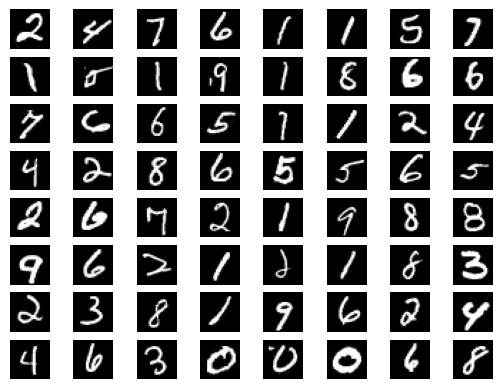

In [90]:
dataloader = torch.utils.data.DataLoader(
    mnist, batch_size=64,
    shuffle=True, 
    pin_memory=torch.cuda.is_available())

sample,_= next(iter(dataloader))

plt.figure()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(sample[i][0], cmap="gray")
    plt.axis('off')

plt.savefig('sample')


In [91]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

dataloader = torch.utils.data.DataLoader(
    mnist, batch_size=batch_size,
    shuffle=True, 
    pin_memory=torch.cuda.is_available())

print('Number of samples: ', len(mnist))

Number of samples:  60000


In [92]:
losses = [[],[],[],[]] # to store KL loss after each epoch
losses_r = [[],[],[],[]] # to store reconstruction loss after each epoch
images = [[],[],[],[]] # to store images generatd by the generator

In [93]:
sample = sample.view(-1,input_dim).to(device)

In [94]:
for index,latent_size in enumerate(latent_size_list):
    encoder = Encoder(input_dim, hidden_size, latent_size)
    decoder = Decoder(latent_size, hidden_size, input_dim)
    iwae = IWAE(encoder, decoder, k, 1000).to(device)
    optimizer = optim.Adam(iwae.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        i=0
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.view(-1, input_dim).to(device)
            optimizer.zero_grad()
            reconstructions, q_z, z_samples = iwae(inputs)
            loss = iwae.loss(inputs, reconstructions, q_z, z_samples)
            loss.backward()
            optimizer.step()
            l = loss.item()
            losses[index].append(l)
            if(i%10 == 0):
                sample_d,_,_ = iwae(sample)
                sample_image = sample_d[0].loc.view(-1,1,28,28)
                generated_img = make_grid(sample_image)
                save_generator_image(generated_img, f"./output-{latent_size}/latent{latent_size}_sample_round{i + 190*epoch}.png")
                images[index].append(generated_img)
                NLL = iwae.NLL(inputs)
                print(latent_size, epoch, i, l, NLL.item())
            i+=1
        torch.save(iwae.state_dict(), f'./output-{latent_size}/iwae{latent_size}.pth')
        imgs = [np.array(to_pil_image(img)) for img in images[index]]
        imageio.mimsave(f'./output-{latent_size}/{latent_size}-latent-sample_images.gif', imgs)


2 0 0 828.3599853515625 -802.1524047851562
2 0 10 751.1481323242188 -753.0601806640625
2 0 20 751.3384399414062 -752.7544555664062
2 0 30 748.3023681640625 -749.9094848632812
2 0 40 746.5606689453125 -748.4210205078125
2 0 50 746.0042724609375 -747.89990234375
2 0 60 745.2070922851562 -747.24365234375
2 0 70 744.440185546875 -746.5498046875
2 0 80 744.5628662109375 -746.7347412109375
2 0 90 744.2622680664062 -746.3670654296875
2 0 100 743.63134765625 -745.8580322265625
2 0 110 743.7947998046875 -746.00732421875
2 0 120 742.6298217773438 -744.916259765625
2 0 130 743.191650390625 -745.437744140625
2 0 140 743.2255249023438 -745.526611328125
2 0 150 742.9365844726562 -745.3659057617188
2 0 160 743.0638427734375 -745.5572509765625
2 0 170 742.7075805664062 -745.12255859375
2 0 180 742.5188598632812 -745.0133666992188
2 0 190 743.026611328125 -745.5081176757812
2 1 0 742.4134521484375 -744.83154296875
2 1 10 742.6839599609375 -745.135009765625
2 1 20 741.7839965820312 -744.3499145507812
2 

In [95]:
for index,latent_size in enumerate(latent_size_list):
    encoder = Encoder(input_dim, hidden_size, latent_size)
    decoder = Decoder(latent_size, hidden_size, input_dim)
    iwae = IWAE(encoder, decoder, 5, 100).to(device)
    optimizer = optim.Adam(iwae.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        i=0
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.view(-1, input_dim).to(device)
            optimizer.zero_grad()
            p_x, q_z, z_samples = iwae(inputs)
            log_weights_lst = []
            # Compute log weights
            for j in range(k):
                log_likelihoods = p_x[j].log_prob(inputs).sum(-1)
                log_weights = log_likelihoods - kls
                log_weights_lst.append(log_weights)
            # Use the log-sum-exp trick
            log_sum = torch.logsumexp(torch.stack(log_weights_lst), dim=0) - torch.log(torch.tensor(float(k)))
            loss = - log_sum.mean(0)
            loss.backward()
            optimizer.step()
            l = loss.item()
            losses[index].append(l)
            if(i%10 == 0):
                sample_d,_= iwae(sample)
                sample_image = sample_d[0].loc.view(-1,1,28,28)
                generated_img = make_grid(sample_image)
                save_generator_image(generated_img, f"./output-{latent_size}/latent{latent_size}_sample_round{i + 190*epoch}.png")
                images[index].append(generated_img)
                print(latent_size, epoch, i, l)
            i+=1
        torch.save(iwae.state_dict(), f'./output-{latent_size}/iwae{latent_size}.pth')
        imgs = [np.array(to_pil_image(img)) for img in images[index]]
        imageio.mimsave(f'./output-{latent_size}/{latent_size}-latent-sample_images.gif', imgs)


NameError: name 'kls' is not defined

In [ ]:
plt.figure()
for i,loss in enumerate(losses):
    plt.plot(loss, label=f'latent dimension {latent_size_list[i]}-KL loss')
plt.savefig('./loss.png')
plt.legend()
plt.figure()
print(len(losses_r))
for i,loss_r in enumerate(losses_r):   
    plt.plot(loss_r, label=f'latent dimension {latent_size_list[i]}-reconstruct likelihood')
    plt.legend()
plt.savefig('./loss_r.png')
